# Projeto ML I — Classificação Binária (ARTESP **Acidentes_2025 CSV**)

**Autor:** Marlon Vinícius Sobania - Id: 1486037

**Tuma:** CAIXAVERSO - 03 | Especialista em IA - II | #1486

**Data:** 2025-10-23

**Link dataset:** https://dadosabertos.artesp.sp.gov.br/en/dataset/acidentes/resource/287f0b63-6188-4ff8-bd51-429a9876c87a

## Storytelling (Contexto do Problema)
A ARTESP disponibiliza dados públicos sobre acidentes em rodovias concedidas do Estado de São Paulo.
Neste projeto, usaremos **exclusivamente** o recurso **Acidentes_2025 CSV** para prever a **fatalidade** de um acidente.

- **Alvo binário:** `fatal` = 1 se houve pelo menos **uma vítima fatal**; 0 caso contrário.
- **Variáveis típicas:** rodovia, KM, município, tipo de acidente, clima, visibilidade, tipo de pista, tipo de veículo, etc.
- **Esquema 2025:** colunas de vítimas no padrão **`QTD_VIT_*`** (ex.: `QTD_VIT_FATAL`, `QTD_VIT_ILESA`).

**Problema:** _Quais fatores mais contribuem para a ocorrência de fatalidade em 2025 nas rodovias concedidas?_

**Objetivo técnico:** montar um pipeline completo de ML (EDA → Pré-processamento → Modelagem → Avaliação → Explicabilidade) e, como extra, serializar um modelo para servir via API.

> **Observação:** este notebook está **fixado em 2025** e usa a coluna `QTD_VIT_FATAL` como target padrão.


## 1. Importação de bibliotecas

In [1]:
%pip install -U imbalanced-learn shap fastapi uvicorn joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 7.6 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 8.1 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.3/555.3 kB 12.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 12.4 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 8.8 MB/s  0:00:04 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20/20 [fastapi]9/20 [fastapi]]arn]]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# (Opcional) Instale dependências, se precisar:
# !pip install -U pandas numpy scikit-learn imbalanced-learn shap fastapi uvicorn joblib

import os, glob, joblib, warnings
from typing import List, Optional, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score, roc_curve, auc, precision_recall_fscore_support
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import shap

c:\Users\mvssc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Carregamento da base

- Manter o arquivo **Acidentes_2025.csv** no mesmo diretório deste notebook.


In [2]:
df = pd.read_csv('acidentes_2025.csv', sep=',', encoding='utf-8', low_memory=False)
print(f'Dados carregados: {df.shape[0]} linhas e {df.shape[1]} colunas.')
df.head()

Dados carregados: 23137 linhas e 26 colunas.


,NOME_CONC,RODOVIA,MARCO_QM,SENTIDO,DATA,HR_ACID,CLASS_ACID,TIPO_ACID,CAUSA,METEORO,...,QTD_VIT_MODERADA,QTD_VIT_SEM_INFO,TIPO_PISTA,DENOMINACAO,MUNICÍPIO,REGIONAL_DER,JURISDICAO,REG_ADM_SP,LATITUDE,LONGITUDE
0,COLINAS,SP075,46.78,SUL,2025-01-01,00:04,ATROPELAMENTO DE ANIMAL,ATROP. ANIMAL,ANIMAL NA RODOVIA,BOA,...,0,0,DUPLA,ENG. ERMÊNIO DE OLIVEIRA PENTEADO,INDAIATUBA,CAMPINAS,ESTADUAL,CAMPINAS,-23.149664,-47.254411
1,VIAOESTE,SP270,108.63,LESTE,2025-01-01,00:14,ATROPELAMENTO DE ANIMAL,ATROP. ANIMAL,ANIMAL NA RODOVIA,BOA,...,0,0,DUPLA,RAPOSO TAVARES,SOROCABA,ITAPETININGA,ESTADUAL,SOROCABA,-23.519805,-47.533992
2,SPVIAS,SP255,259.90,NORTE,2025-01-01,00:16,ATROPELAMENTO DE ANIMAL,ATROP. ANIMAL,ANIMAL NA RODOVIA,BOA,...,0,0,DUPLA,JOÃO MELLÃO,AVARÉ,ITAPETININGA,ESTADUAL,SOROCABA,-23.115401,-48.940301
3,RENOVIAS,SP342,173.50,OESTE,2025-01-01,00:20,ATROPELAMENTO DE PEDESTRE,ATROP. PEDESTRE-OUTROS,IMPRUD. PEDESTRE-MORADOR,CHUVA,...,0,0,DUPLA,GOV. DR. ADHEMAR PEREIRA DE BARROS (SP 342),MOGI GUAÇU,RIO CLARO,ESTADUAL,CAMPINAS,-22.340500,-46.943600
4,VIAPAULISTA,SP345,35.00,OESTE,2025-01-01,00:31,ATROPELAMENTO DE PEDESTRE,ATROP. PEDESTRE-MORADOR/TRABALHADOR/ESTUDANTE,IMPRUD. PEDESTRE-USUÁRIO,BOA,...,1,0,DUPLA,ENG. RONAN ROCHA,FRANCA,RIBEIRÃO PRETO,ESTADUAL,FRANCA,-20.566678,-47.407910


## 3. Análise Exploratória e Criação do Alvo

- Conferimos tipos/ausentes rapidamente
- Definimos **alvo binário** a partir de `QTD_VIT_FATAL` > 0 → `fatal` = 1; 0 caso contrário


In [3]:
coluna_alvo_manual: Optional[str] = 'QTD_VIT_FATAL'

if coluna_alvo_manual not in df.columns:
    normalizado = {c.lower().replace('_',''): c for c in df.columns}
    chave = 'qtdvitfatal'
    if chave in normalizado:
        coluna_alvo_manual = normalizado[chave]
    else:
        raise ValueError("Coluna 'QTD_VIT_FATAL' não encontrada no CSV 2025. Ajuste 'coluna_alvo_manual'.")

coluna_fatal = coluna_alvo_manual
print("Coluna de vítimas fatais:", coluna_fatal)

dados = df.copy()
contagem_fatal = (
    dados[coluna_fatal]
    .astype(str)
    .str.replace(',', '.', regex=False)
    .str.extract(r'([\d\.]+)', expand=False)
    .fillna('0')
    .astype(float)
)
dados['fatal'] = (contagem_fatal > 0).astype(int)
print("Proporção de classe (fatal=1):", dados['fatal'].mean())


Coluna de vítimas fatais: QTD_VIT_FATAL
Proporção de classe (fatal=1): 0.025586722565587586


In [4]:
ausentes = dados.isna().mean().sort_values(ascending=False).to_frame('pct_ausente')
tipos = dados.dtypes.astype(str).to_frame('tipo')
resumo = ausentes.join(tipos, how='outer').sort_values('pct_ausente', ascending=False)
resumo.head(20)


,pct_ausente,tipo
MUNICÍPIO,0.012923,object
JURISDICAO,0.012923,object
DENOMINACAO,0.012923,object
REG_ADM_SP,0.012923,object
REGIONAL_DER,0.012923,object
TIPO_PISTA,0.000173,object
DATA,0.000000,object
LATITUDE,0.000000,float64
CLASS_ACID,0.000000,object
CAUSA,0.000000,object


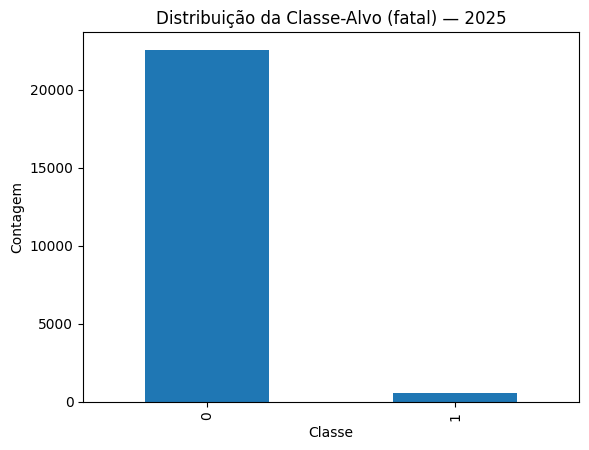

In [5]:
contagens = dados['fatal'].value_counts().sort_index()
plt.figure()
contagens.plot(kind='bar')
plt.title('Distribuição da Classe-Alvo (fatal) — 2025')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.show()


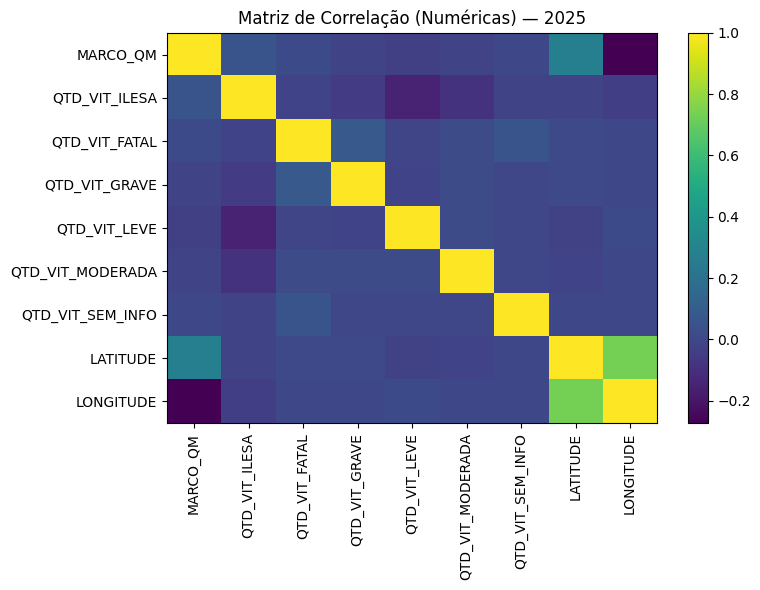

In [6]:
colunas_numericas = dados.select_dtypes(include=[np.number]).columns.tolist()
if 'fatal' in colunas_numericas:
    colunas_numericas.remove('fatal')

if len(colunas_numericas) > 0:
    corr = dados[colunas_numericas].corr(numeric_only=True)
    plt.figure(figsize=(8, 6))
    plt.imshow(corr, interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.title('Matriz de Correlação (Numéricas) — 2025')
    plt.xticks(range(len(colunas_numericas)), colunas_numericas, rotation=90)
    plt.yticks(range(len(colunas_numericas)), colunas_numericas)
    plt.tight_layout()
    plt.show()
else:
    print("Não há colunas numéricas além do alvo após o parsing inicial.")


##### CONCLUSÃO SOBRE A ANÁLISE EXPLORATÓRIA DE DADOS:

Desbalanceamento forte: fatal=1 aprox. 2,56%.

Quantidade baixa de NaN: só ~1,3% em alguns campos categóricos (MUNICÍPIO, JURISDICAO, etc.).

Vazamento/leaking: as colunas QTD_VIT_* (inclui QTD_VIT_FATAL) são resultado do acidente. Se ficarem nas features, o modelo “adivinha” o alvo. Vamos removê-las das variáveis explicativas.

In [14]:
alvo = 'fatal'

# 1) Padrões de vazamento: vítimas, gravidade, desfecho
padroes_suspeitos = ['QTD_VIT_', 'CLASS', 'GRAV', 'SEVER', 'DESFE', 'EVOLU', 'FATAL', 'OBITO', 'ÓBITO', 'LES']

colunas_suspeitas = [c for c in dados.columns if any(p in c.upper() for p in padroes_suspeitos)]

# 2) Remoções explícitas que costumam vazar
remocoes_explicitas = ['CLASS_ACID']  # ajuste se seu CSV tiver variações

# 3) (Opcional, por ora) tirar coordenadas para evitar memorização de pontos únicos
# remocoes_explicitas += ['LATITUDE', 'LONGITUDE']

colunas_a_remover = set(colunas_suspeitas + remocoes_explicitas + [alvo])

colunas_explicativas = [c for c in dados.columns if c not in colunas_a_remover]
colunas_numericas   = [c for c in colunas_explicativas if pd.api.types.is_numeric_dtype(dados[c])]
colunas_categoricas = [c for c in colunas_explicativas if c not in colunas_numericas]

print("Removidas (suspeitas de vazamento):", sorted(colunas_suspeitas + remocoes_explicitas))
print("Total de features finais:", len(colunas_explicativas))

Removidas (suspeitas de vazamento): ['CLASS_ACID', 'CLASS_ACID', 'QTD_VIT_FATAL', 'QTD_VIT_GRAVE', 'QTD_VIT_ILESA', 'QTD_VIT_LEVE', 'QTD_VIT_MODERADA', 'QTD_VIT_SEM_INFO', 'fatal']
Total de features finais: 19


In [15]:
# ================== LIMPEZA DE VAZAMENTO ==================
alvo = 'fatal'

# Padrões que indicam desfecho/gravidade (vazamento)
padroes_suspeitos = ['QTD_VIT_', 'CLASS', 'GRAV', 'SEVER', 'DESFE', 'EVOLU', 'FATAL', 'OBITO', 'ÓBITO', 'LES']

# Quais colunas do DF batem nesses padrões?
colunas_suspeitas = [c for c in dados.columns if any(p in c.upper() for p in padroes_suspeitos)]

# Remoções explícitas (garantia)
remocoes_explicitas = ['CLASS_ACID']  # acrescente variações se existirem no seu CSV

# (Opcional por enquanto) Remover coordenadas para evitar “memorizar” pontos únicos
# remocoes_explicitas += ['LATITUDE', 'LONGITUDE']

colunas_para_remover = sorted(set(colunas_suspeitas + remocoes_explicitas + [alvo]))

print("Removendo do DF:", colunas_para_remover)

# >>>> DROP NO DATAFRAME <<<<  (isso "blinda" o restante do fluxo)
dados_limpos = dados.drop(columns=[c for c in colunas_para_remover if c in dados.columns], errors='ignore').copy()

# ================== REDEFINIÇÃO DE FEATURES ==================
colunas_explicativas = [c for c in dados_limpos.columns if c != alvo]
colunas_numericas   = [c for c in colunas_explicativas if pd.api.types.is_numeric_dtype(dados_limpos[c])]
colunas_categoricas = [c for c in colunas_explicativas if c not in colunas_numericas]

print("Total de features:", len(colunas_explicativas))
print("Numéricas:", len(colunas_numericas), " | Categóricas:", len(colunas_categoricas))

# ================== RECRIA O PREPROCESSADOR (AGORA LIMPO) ==================
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

pipeline_numerico = Pipeline(steps=[
    ('imputador', SimpleImputer(strategy='median')),
    ('escala', RobustScaler())
])

pipeline_categorico = Pipeline(steps=[
    ('imputador', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessador = ColumnTransformer(
    transformers=[
        ('num', pipeline_numerico, colunas_numericas),
        ('cat', pipeline_categorico, colunas_categoricas),
    ]
)

# ================== CHECAGEM RÁPIDA (sem precisar dar fit) ==================
proibidas = set([c for c in colunas_para_remover if c != alvo])
transformers_lista = getattr(preprocessador, "transformers", None)  # antes do fit é .transformers
vazou = False
for nome, transf, cols in transformers_lista:
    inter = set(cols) & proibidas
    if inter:
        vazou = True
        print("⚠️ Vazamento no transformador", nome, "→", sorted(inter))
if not vazou:
    print("✅ Nenhuma coluna proibida está no preprocessador.")

# ================== DEFINA X, y A PARTIR DO DF LIMPO ==================
X = dados_limpos[colunas_explicativas].copy()
y = dados[alvo].copy()  # o alvo continua vindo do DF original

Removendo do DF: ['CLASS_ACID', 'QTD_VIT_FATAL', 'QTD_VIT_GRAVE', 'QTD_VIT_ILESA', 'QTD_VIT_LEVE', 'QTD_VIT_MODERADA', 'QTD_VIT_SEM_INFO', 'fatal']
Total de features: 19
Numéricas: 3  | Categóricas: 16
✅ Nenhuma coluna proibida está no preprocessador.


## 4. Pré-processamento (Pipeline + ColumnTransformer)

- **Imputação**: numéricas (mediana), categóricas (mais frequente)
- **Codificação**: `OneHotEncoder`
- **Escala**: `RobustScaler`
- **Balanceamento**: `SMOTE` (se disponível) ou `class_weight='balanced'`
- **PCA (opcional)** após OHE


In [16]:
# --- usar dados_limpos ---
alvo = 'fatal'
X = dados_limpos.copy()
y = dados[alvo].copy()

colunas_explicativas = list(X.columns)  # 'fatal' já não está em dados_limpos
colunas_numericas   = [c for c in colunas_explicativas if pd.api.types.is_numeric_dtype(X[c])]
colunas_categoricas = [c for c in colunas_explicativas if c not in colunas_numericas]

pipeline_numerico = Pipeline(steps=[
    ('imputador', SimpleImputer(strategy='median')),
    ('escala', RobustScaler())
])
pipeline_categorico = Pipeline(steps=[
    ('imputador', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessador = ColumnTransformer(
    transformers=[
        ('num', pipeline_numerico, colunas_numericas),
        ('cat', pipeline_categorico, colunas_categoricas),
    ]
)

# (opcional) checagem rápida
proibidas = {'CLASS_ACID','QTD_VIT_FATAL','QTD_VIT_GRAVE','QTD_VIT_ILESA','QTD_VIT_LEVE','QTD_VIT_MODERADA','QTD_VIT_SEM_INFO'}
for nome, transf, cols in preprocessador.transformers:
    assert not (set(cols) & proibidas)

## 5. Treinamento, Validação e Teste (aleatório estratificado)

- Split estratificado (treino/teste)
- Validação cruzada (StratifiedKFold)
- Modelos: Logística, Árvore, RandomForest, SVM


In [10]:
semente = 42
tamanho_teste = 0.2

IMB_DISPONIVEL = globals().get('IMB_DISPONIVEL', 'ImbPipeline' in globals())

X = dados[colunas_explicativas].copy()
y = dados[alvo].copy()

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=tamanho_teste, stratify=y, random_state=semente)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=semente)

def construir_pipeline(est, usar_smote: bool = True):
    etapas = [('pre', preprocessador)]
    if usar_pca:
        etapas.append(etapa_pca)
    if IMB_DISPONIVEL and usar_smote:
        etapas.append(('smote', SMOTE(random_state=semente)))
    etapas.append(('modelo', est))
    return ImbPipeline(etapas) if IMB_DISPONIVEL else Pipeline(etapas)

logistica = LogisticRegression(max_iter=300, class_weight=None if IMB_DISPONIVEL else 'balanced')
arvore = DecisionTreeClassifier(random_state=semente, class_weight=None if IMB_DISPONIVEL else 'balanced')
floresta = RandomForestClassifier(n_estimators=300, random_state=semente, n_jobs=-1, class_weight=None if IMB_DISPONIVEL else 'balanced')
svm_clf = SVC(probability=True, random_state=semente, class_weight=None if IMB_DISPONIVEL else 'balanced')

modelos = {
    'RegressaoLogistica': construir_pipeline(logistica),
    'ArvoreDecisao': construir_pipeline(arvore),
    'RandomForest': construir_pipeline(floresta),
    'SVM': construir_pipeline(svm_clf),
}

def cv_roc_auc(pipe, X, y, cv):
    escores = cross_val_score(pipe, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    return escores.mean(), escores.std()

resultados_baseline = {}
for nome, pipe in modelos.items():
    media_auc, desvio_auc = cv_roc_auc(pipe, X_treino, y_treino, cv)
    resultados_baseline[nome] = {'roc_auc_cv_media': media_auc, 'roc_auc_cv_dp': desvio_auc}

pd.DataFrame(resultados_baseline).T.sort_values('roc_auc_cv_media', ascending=False)


,roc_auc_cv_media,roc_auc_cv_dp
RegressaoLogistica,1.000000,0.000000
ArvoreDecisao,1.000000,0.000000
SVM,0.999996,0.000007
RandomForest,0.999922,0.000070


In [ ]:
melhor_nome = max(resultados_baseline, key=lambda k: resultados_baseline[k]['roc_auc_cv_media'])
melhor_pipe = modelos[melhor_nome]
print(f"Modelo baseline selecionado: {melhor_nome}")

melhor_pipe.fit(X_treino, y_treino)
y_pred = melhor_pipe.predict(X_teste)
y_prob = melhor_pipe.predict_proba(X_teste)[:, 1]

print(classification_report(y_teste, y_pred, digits=4))

cm = confusion_matrix(y_teste, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.title(f'Matriz de Confusão — {melhor_nome} (baseline, aleatório)')
plt.show()

auc_teste = roc_auc_score(y_teste, y_prob)
fpr, tpr, _ = roc_curve(y_teste, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'{melhor_nome} (AUC={auc_teste:.3f})')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title('Curva ROC — Teste aleatório')
plt.legend()
plt.show()


## 5.1 Validação Temporal (hold-out nov–dez/2025)

Roteiro:
1. Detectar a coluna de data e criar atributos de tempo (`MES`, `DIA_SEMANA`, `HORA`, `FIM_DE_SEMANA`).
2. Treinar com dados de jan–out/2025 e testar em nov–dez/2025.
3. Comparar métricas com o teste aleatório.

> Se a performance cair no teste temporal, avalie: threshold orientado a recall, calibração e features de tempo adicionais.


In [ ]:
def detectar_coluna_data(df: pd.DataFrame) -> Optional[str]:
    candidatos = [c for c in df.columns if 'data' in c.lower() or 'dt_' in c.lower() or 'hora' in c.lower()]
    preferencia = ['DATA_HORA', 'DATAHORA', 'DATA', 'DT_ACID', 'DT_EVENTO', 'HORA']
    for p in preferencia:
        for col in df.columns:
            if col.upper() == p:
                return col
    if candidatos:
        return candidatos[0]
    return None

def criar_atributos_temporais(df: pd.DataFrame, nome_coluna_data: str) -> pd.DataFrame:
    dados_temp = df.copy()
    serie = pd.to_datetime(dados_temp[nome_coluna_data], errors='coerce', dayfirst=True, infer_datetime_format=True)
    dados_temp['MES'] = serie.dt.month
    dados_temp['DIA_SEMANA'] = serie.dt.weekday
    dados_temp['HORA'] = serie.dt.hour.fillna(0).astype(int)
    dados_temp['FIM_DE_SEMANA'] = dados_temp['DIA_SEMANA'].isin([5,6]).astype(int)
    return dados_temp

col_data = detectar_coluna_data(dados)
if col_data is None:
    print('Não foi possível detectar uma coluna de data/hora. Ajuste manualmente a variável col_data, se existir.')

dados_temporais = criar_atributos_temporais(dados, col_data) if col_data is not None else dados.copy()
if 'MES' not in dados_temporais.columns:
    raise RuntimeError("A coluna 'MES' não está presente. Ajuste a detecção da data na célula acima.")


In [ ]:
mascara_treino_temporal = dados_temporais['MES'] <= 10
X_temporal = dados_temporais[colunas_explicativas].copy()
y_temporal = dados_temporais[alvo].copy()

for nova in ['MES','DIA_SEMANA','HORA','FIM_DE_SEMANA']:
    if nova in dados_temporais.columns and nova not in X_temporal.columns:
        X_temporal[nova] = dados_temporais[nova]

X_treino_tmp, y_treino_tmp = X_temporal[mascara_treino_temporal], y_temporal[mascara_treino_temporal]
X_teste_tmp,  y_teste_tmp  = X_temporal[~mascara_treino_temporal], y_temporal[~mascara_treino_temporal]
print('Formato treino temporal:', X_treino_tmp.shape, ' — teste temporal:', X_teste_tmp.shape)


In [ ]:
colunas_numericas_tmp = [c for c in X_treino_tmp.columns if pd.api.types.is_numeric_dtype(X_treino_tmp[c])]
colunas_categoricas_tmp = [c for c in X_treino_tmp.columns if c not in colunas_numericas_tmp]

pipeline_numerico_tmp = Pipeline(steps=[('imputador', SimpleImputer(strategy='median')), ('escala', RobustScaler())])
pipeline_categorico_tmp = Pipeline(steps=[('imputador', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessador_tmp = ColumnTransformer([
    ('num', pipeline_numerico_tmp, colunas_numericas_tmp),
    ('cat', pipeline_categorico_tmp, colunas_categoricas_tmp)
])

def construir_pipeline_temporal(est, usar_smote: bool = True):
    etapas = [('pre', preprocessador_tmp)]
    if usar_pca:
        etapas.append(etapa_pca)
    if IMB_DISPONIVEL and usar_smote:
        etapas.append(('smote', SMOTE(random_state=42)))
    etapas.append(('modelo', est))
    return ImbPipeline(etapas) if IMB_DISPONIVEL else Pipeline(etapas)

modelo_temporal = construir_pipeline_temporal(RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
modelo_temporal.fit(X_treino_tmp, y_treino_tmp)
y_pred_tmp = modelo_temporal.predict(X_teste_tmp)
y_prob_tmp = modelo_temporal.predict_proba(X_teste_tmp)[:, 1]

print(classification_report(y_teste_tmp, y_pred_tmp, digits=4))
cm_tmp = confusion_matrix(y_teste_tmp, y_pred_tmp, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tmp, display_labels=[0,1])
disp.plot()
plt.title('Matriz de Confusão — Hold-out Temporal (nov–dez/2025)')
plt.show()

auc_tmp = roc_auc_score(y_teste_tmp, y_prob_tmp)
fpr_tmp, tpr_tmp, _ = roc_curve(y_teste_tmp, y_prob_tmp)
plt.figure()
plt.plot(fpr_tmp, tpr_tmp, label=f'Hold-out Temporal (AUC={auc_tmp:.3f})')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title('Curva ROC — Hold-out Temporal (nov–dez/2025)')
plt.legend()
plt.show()


## 5.2 (Opcional) Validação por blocos mensais (Leave-One-Month-Out)

Avalia estabilidade do modelo ao deixar **um mês de 2025** de fora por rodada (GroupKFold com `MES`).


In [ ]:
def auc_por_mes(modelo_base, X_df: pd.DataFrame, y_series: pd.Series, mes_series: pd.Series) -> pd.DataFrame:
    grupos = mes_series.values
    kfold = GroupKFold(n_splits=len(np.unique(grupos)))
    resultados = []
    for treino_idx, teste_idx in kfold.split(X_df, y_series, groups=grupos):
        mes_val = int(np.unique(grupos[teste_idx])[0])
        X_tr, X_te = X_df.iloc[treino_idx], X_df.iloc[teste_idx]
        y_tr, y_te = y_series.iloc[treino_idx], y_series.iloc[teste_idx]

        cols_num = [c for c in X_tr.columns if pd.api.types.is_numeric_dtype(X_tr[c])]
        cols_cat = [c for c in X_tr.columns if c not in cols_num]
        pre = ColumnTransformer([
            ('num', Pipeline([('imputador', SimpleImputer(strategy='median')), ('escala', RobustScaler())]), cols_num),
            ('cat', Pipeline([('imputador', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), cols_cat)
        ])
        etapas = [('pre', pre)]
        if IMB_DISPONIVEL:
            etapas.append(('smote', SMOTE(random_state=42)))
        etapas.append(('modelo', modelo_base))
        pipe = ImbPipeline(etapas) if IMB_DISPONIVEL else Pipeline(etapas)

        pipe.fit(X_tr, y_tr)
        y_prob = pipe.predict_proba(X_te)[:, 1]
        resultados.append({'mes_validado': mes_val, 'roc_auc': roc_auc_score(y_te, y_prob)})
    return pd.DataFrame(resultados).sort_values('mes_validado')

if 'MES' in dados_temporais.columns:
    X_grupos = X_temporal.copy()
    for nova in ['MES','DIA_SEMANA','HORA','FIM_DE_SEMANA']:
        if nova in dados_temporais.columns and nova not in X_grupos.columns:
            X_grupos[nova] = dados_temporais[nova]
    df_auc_mensal = auc_por_mes(RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1),
                                X_grupos, y_temporal, dados_temporais['MES'])
    df_auc_mensal
else:
    print('Sem coluna MES; não é possível realizar a validação por blocos mensais.')


In [ ]:
if 'df_auc_mensal' in globals():
    plt.figure()
    plt.plot(df_auc_mensal['mes_validado'], df_auc_mensal['roc_auc'], marker='o')
    plt.xlabel('Mês validado (1–12)')
    plt.ylabel('ROC-AUC')
    plt.title('AUC por mês — Leave-One-Month-Out')
    plt.xticks(range(1,13))
    plt.grid(True)
    plt.show()


## 6. Otimização de hiperparâmetros (ex.: RandomForest)

In [ ]:
grade_parametros = {
    'modelo__n_estimators': [200, 400, 600],
    'modelo__max_depth': [None, 6, 12, 18],
    'modelo__min_samples_split': [2, 5, 10],
    'modelo__min_samples_leaf': [1, 2, 4]
}

rf_para_tuning = construir_pipeline(RandomForestClassifier(random_state=42, n_jobs=-1))
grid = GridSearchCV(rf_para_tuning, param_grid=grade_parametros, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_treino, y_treino)
print('Melhores parâmetros:', grid.best_params_)
print('Melhor ROC-AUC (cv):', grid.best_score_)
modelo_ajustado = grid.best_estimator_


## 7. Avaliação (teste) & 8. Comparativo de modelos

In [ ]:
def avaliar_no_teste(nome_modelo: str, modelo, X_te, y_te) -> Dict[str, float]:
    y_pred = modelo.predict(X_te)
    y_prob = modelo.predict_proba(X_te)[:, 1]
    prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred, average='binary', zero_division=0)
    roc = roc_auc_score(y_te, y_prob)
    return {'precisao': prec, 'revocacao': rec, 'f1': f1, 'roc_auc': roc}

res_baseline = avaliar_no_teste(melhor_nome, melhor_pipe, X_teste, y_teste)
res_ajustado = avaliar_no_teste('RandomForest (ajustado)', modelo_ajustado, X_teste, y_teste)
comparativo = pd.DataFrame([res_baseline, res_ajustado], index=[melhor_nome, 'RandomForest (ajustado)'])
comparativo


In [ ]:
plt.figure()
for nome, modelo in [(melhor_nome, melhor_pipe), ('RandomForest (ajustado)', modelo_ajustado)]:
    y_prob = modelo.predict_proba(X_teste)[:, 1]
    fpr, tpr, _ = roc_curve(y_teste, y_prob)
    valor_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{nome} (AUC={valor_auc:.3f})')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title('Curvas ROC — Teste (aleatório)')
plt.legend()
plt.show()


## 9. Explicabilidade (importâncias e SHAP opcional)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def nomes_atributos_do_transformador(ct: ColumnTransformer) -> List[str]:
    saida = []
    for nome, transf, cols in ct.transformers_:
        if nome == 'remainder' and transf == 'drop':
            continue
        if hasattr(transf, 'named_steps'):
            ultimo = list(transf.named_steps.values())[-1]
            if isinstance(ultimo, OneHotEncoder):
                ohe: OneHotEncoder = ultimo
                categorias = ohe.get_feature_names_out(cols)
                saida.extend(categorias.tolist())
            else:
                saida.extend(cols if isinstance(cols, list) else list(cols))
        else:
            saida.extend(cols if isinstance(cols, list) else list(cols))
    return saida

modelo_final = modelo_ajustado if 'RandomForest' in str(modelo_ajustado) else melhor_pipe
est_final = modelo_final.named_steps.get('modelo', None)

if hasattr(est_final, 'feature_importances_'):
    modelo_final.fit(X_treino, y_treino)
    _ = modelo_final.named_steps['pre'].fit_transform(X_treino)
    nomes_cols = nomes_atributos_do_transformador(modelo_final.named_steps['pre'])
    importancias = pd.Series(est_final.feature_importances_, index=nomes_cols).sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    importancias.iloc[::-1].plot(kind='barh')
    plt.title('Importâncias de Atributos (Top 20)')
    plt.tight_layout()
    plt.show()

if SHAP_DISPONIVEL and (hasattr(est_final, 'estimators_') or hasattr(est_final, 'feature_importances_')):
    try:
        explicador = shap.TreeExplainer(est_final)
        X_pre = modelo_final.named_steps['pre'].transform(X_teste)
        valores_shap = explicador.shap_values(X_pre)
        shap.summary_plot(valores_shap, X_pre, show=False)
        plt.title('SHAP Summary (árvore)')
        plt.show()
    except Exception as e:
        print('Falha ao calcular SHAP:', e)
else:
    print('SHAP não disponível ou modelo não compatível; seção opcional pulada.')


## 10. Produtização (artefato + API)

In [ ]:
caminho_artefatos = 'artefatos'
os.makedirs(caminho_artefatos, exist_ok=True)
caminho_modelo = os.path.join(caminho_artefatos, 'pipeline_modelo_2025.joblib')

modelo_final.fit(X_treino, y_treino)
joblib.dump(modelo_final, caminho_modelo)
print(f'Artefato salvo em: {caminho_modelo}')


In [ ]:
codigo_api = (
    "from fastapi import FastAPI\n"
    "import joblib\n"
    "import pandas as pd\n\n"
    "app = FastAPI(title=\"ARTESP 2025 — Fatalidade API\")\n"
    "modelo = joblib.load(\"artefatos/pipeline_modelo_2025.joblib\")\n\n"
    "@app.post(\"/predict\")\n"
    "def prever(payload: dict):\n"
    "    X = pd.DataFrame([payload])\n"
    "    proba = modelo.predict_proba(X)[:, 1][0]\n"
    "    pred = int(proba >= 0.5)\n"
    "    return {\"predicao\": pred, \"probabilidade\": float(proba)}\n"
)
with open('app.py', 'w', encoding='utf-8') as f:
    f.write(codigo_api)
print('Arquivo app.py gerado. Para executar:')
print('  uvicorn app:app --reload --port 8000')
print('Exemplo de requisição:')
print('''\ncurl -X POST "http://127.0.0.1:8000/predict" -H "Content-Type: application/json" -d '{ "RODOVIA": "SP-280", "KM": 50, "MUNICIPIO": "Barueri", "TIPO_ACIDENTE": "Colisão", "CLIMA": "Chuva", "VISIBILIDADE": "Ruim" }'\n''')


## 11. Guia rápido de interpretação e insights (para você preencher após rodar)

1. **Aleatório vs. Temporal**: descreva se houve queda de AUC/Recall no temporal; ajuste threshold/calibração se necessário.
2. **Atributos-chave**: cite top-5 importâncias e discuta coerência (clima, visibilidade, horário, tipo de via/veículo).
3. **AUC por mês** (seção 5.2): identifique meses críticos e proponha hipóteses (sazonalidade, feriados, clima).
4. **Viés/Vazamento**: verifique variáveis proxy ou pós-evento; remova/ajuste e re-treine.
5. **Próximos passos**: calibração (Platt/Isotônico), otimização de threshold por custo, enriquecimento com clima/feriados.
